In [ ]:
#@title Question 2 building basic UNET and nucleus segmentation.
import cv2  # Import open cv2 library
import numpy as np  # Import numpy library
import matplotlib.pyplot as plt # Import Matplotlib 
from google.colab.patches import cv2_imshow # Import cv2_imshow from google colab lib
import os #importing OS 
import sys #importing sys
import random #importing random
import tensorflow as tf #importing tensor flow
from tensorflow import keras #importing keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

from google.colab import drive
drive.mount('/content/drive') # mounting drive content

def scale(img,per): #scaling of an image
    scale_percent = per  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)  # scaling width of main image
    height = int(img.shape[0] * scale_percent / 100)  # scaling height of main image
    dim = (width, height) 
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)  # resizing night image
    return img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path 
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "Tissue-Images", id_name) #concatenates all the paths path+tissueimage+image_id_name
        mask_path = os.path.join(self.path, "Binary-Mask", id_name)
        
        ## Reading both color image and its repective mask.
        image = cv2.imread(image_path, 1)
        mask = cv2.imread(mask_path, -1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        
        ## Reading Masks
  
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : 10*(index+1)*self.batch_size] #appending image files names into files_batch
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img) #image appending
            mask.append(_mask) #mask appending
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

['TCGA-38-6178-01Z-00-DX1.png', 'TCGA-21-5786-01Z-00-DX1.png', 'TCGA-21-5784-01Z-00-DX1.png', 'TCGA-18-5592-01Z-00-DX1.png', 'TCGA-AR-A1AK-01Z-00-DX1.png']
['TCGA-A7-A13F-01Z-00-DX1.png', 'TCGA-A7-A13E-01Z-00-DX1.png', 'TCGA-50-5931-01Z-00-DX1.png', 'TCGA-49-4488-01Z-00-DX1.png', 'TCGA-CH-5767-01Z-00-DX1.png', 'TCGA-B0-5711-01Z-00-DX1.png', 'TCGA-B0-5710-01Z-00-DX1.png', 'TCGA-B0-5698-01Z-00-DX1.png', 'TCGA-AY-A8YK-01A-01-TS1.png', 'TCGA-AR-A1AS-01Z-00-DX1.png', 'TCGA-G9-6336-01Z-00-DX1.png', 'TCGA-G2-A2EK-01A-02-TSB.png', 'TCGA-E2-A1B5-01Z-00-DX1.png', 'TCGA-E2-A14V-01Z-00-DX1.png', 'TCGA-DK-A2I6-01A-01-TS1.png', 'TCGA-HE-7129-01Z-00-DX1.png', 'TCGA-HE-7128-01Z-00-DX1.png', 'TCGA-G9-6363-01Z-00-DX1.png', 'TCGA-G9-6362-01Z-00-DX1.png', 'TCGA-G9-6356-01Z-00-DX1.png', 'TCGA-G9-6348-01Z-00-DX1.png', 'TCGA-RD-A8N9-01A-01-TS1.png', 'TCGA-NH-A8F7-01A-01-TS1.png', 'TCGA-KB-A93J-01A-01-TS1.png', 'TCGA-HE-7130-01Z-00-DX1.png']
(10, 128, 128, 3) (10, 128, 128)


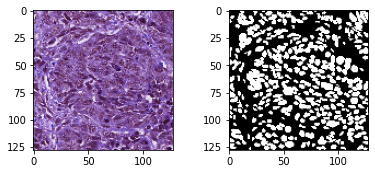

In [ ]:
image_size = 128
epochs = 5
batch_size = 1
train_path="/content/drive/MyDrive/MoNuSeg-Training-Data1"
train_path1="/content/drive/MyDrive/MoNuSeg-Training-Data1/Tissue-Images"
## Training Ids
train_ids=[]
count = 0
for path in os.listdir(train_path1):
    # check if current path is a file
    if os.path.isfile(os.path.join(train_path1, path)):
        train_ids.append(path)

## Validation Data Size
val_data_size = 5

valid_ids = train_ids[0:val_data_size]
train_ids = train_ids[val_data_size:]
print(valid_ids)
print(train_ids)
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)

x, y = gen.__getitem__(0)
print(x.shape, y.shape)
r = random.randint(0, len(x)-1)
# plotting both color image and binary masks.
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")


In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1): #Downsampling Path
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #2DConvolution
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #2DConvolution
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1): #Upsampling Path:
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat) #2DConvolution
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)  #2DConvolution
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1): #skip connection
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x) #2DConvolution
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c) #2DConvolution
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) #unet model compilation
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 128, 128, 16  448         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_191 (Conv2D)            (None, 128, 128, 16  2320        ['conv2d_190[0][0]']             
                                )                                                          

In [ ]:
#@title data training 
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size # computing training steps
valid_steps = len(valid_ids)//batch_size # computing valid steps
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs) # model fitting training data set

25
5
Epoch 1/5
25/25 [==============================] - 82s 3s/step - loss: 0.5894 - acc: 0.7151 - val_loss: 0.5971 - val_acc: 0.6695
Epoch 2/5
25/25 [==============================] - 79s 3s/step - loss: 0.5165 - acc: 0.7179 - val_loss: 0.5387 - val_acc: 0.6696
Epoch 3/5
25/25 [==============================] - 82s 3s/step - loss: 0.4368 - acc: 0.7538 - val_loss: 0.4450 - val_acc: 0.7583
Epoch 4/5
25/25 [==============================] - 79s 3s/step - loss: 0.3889 - acc: 0.7902 - val_loss: 0.4058 - val_acc: 0.7808
Epoch 5/5
25/25 [==============================] - 79s 3s/step - loss: 0.3625 - acc: 0.8056 - val_loss: 0.3957 - val_acc: 0.7893


In [ ]:
#@title Prediction
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 493ms/step


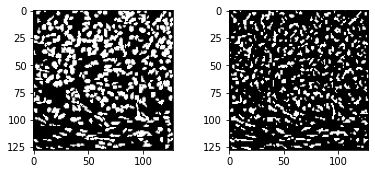

In [ ]:
#@title Train Image, predicted Image
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")


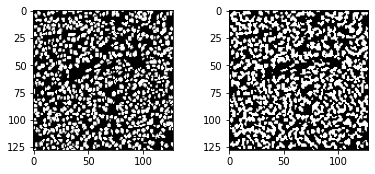

In [ ]:
#@title Train Image, predicted Image
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

1/1 [==============================] - 1s 567ms/step


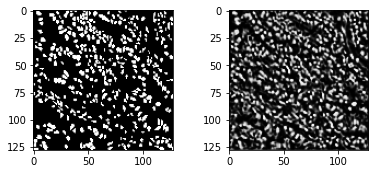

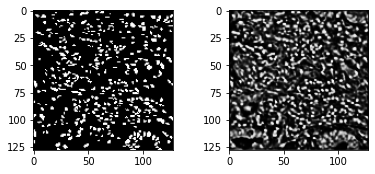

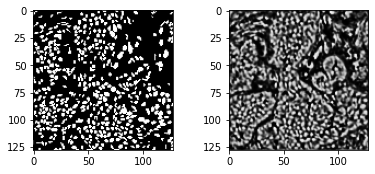

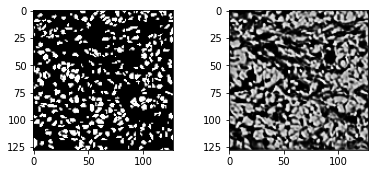

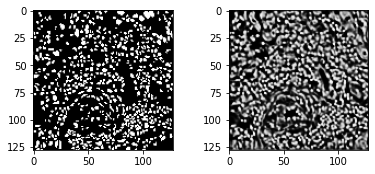

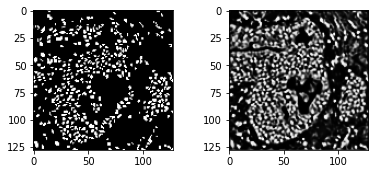

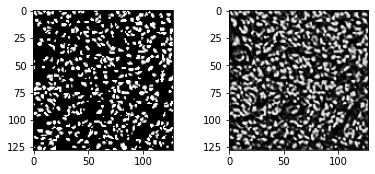

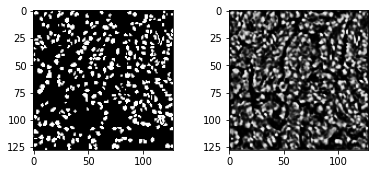

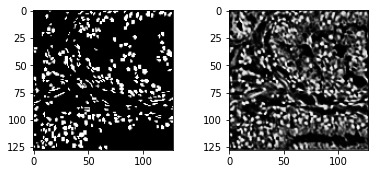

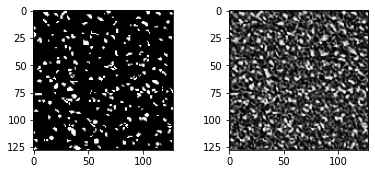

In [ ]:
#@title Test Images, predicted Images
#testing prediction
test_path="/content/drive/MyDrive/MoNuSeg-Test-Data"
test_path1="/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images"
test_ids=[]
for path in os.listdir(test_path1):
    # check if current path is a file
    if os.path.isfile(os.path.join(test_path1, path)):
        test_ids.append(path)
gen_test=DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)
x1,y1=gen_test.__getitem__(2)
predicted = model.predict(x1)
# prediction of 1st test data tissue image
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y1[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(predicted[0]*255, (image_size, image_size)), cmap="gray")

# prediction of 2nd test data tissue image
fig1 = plt.figure()
fig1.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig1.add_subplot(1, 2, 1)
ax1.imshow(np.reshape(y1[1]*255, (image_size, image_size)), cmap="gray")
ax1 = fig1.add_subplot(1, 2, 2)
ax1.imshow(np.reshape(predicted[1]*255, (image_size, image_size)), cmap="gray")

# prediction of 3rd test data tissue image
fig2 = plt.figure()
fig2.subplots_adjust(hspace=0.4, wspace=0.4)
ax2 = fig2.add_subplot(1, 2, 1)
ax2.imshow(np.reshape(y1[2]*255, (image_size, image_size)), cmap="gray")
ax2 = fig2.add_subplot(1, 2, 2)
ax2.imshow(np.reshape(predicted[2]*255, (image_size, image_size)), cmap="gray")

# prediction of 4th test data tissue image
fig3 = plt.figure()
fig3.subplots_adjust(hspace=0.4, wspace=0.4)
ax3 = fig3.add_subplot(1, 2, 1)
ax3.imshow(np.reshape(y1[3]*255, (image_size, image_size)), cmap="gray")
ax3 = fig3.add_subplot(1, 2, 2)
ax3.imshow(np.reshape(predicted[3]*255, (image_size, image_size)), cmap="gray")

# prediction of 5th test data tissue image
fig4 = plt.figure()
fig4.subplots_adjust(hspace=0.4, wspace=0.4)
ax4= fig4.add_subplot(1, 2, 1)
ax4.imshow(np.reshape(y1[4]*255, (image_size, image_size)), cmap="gray")
ax4 = fig4.add_subplot(1, 2, 2)
ax4.imshow(np.reshape(predicted[4]*255, (image_size, image_size)), cmap="gray")

# prediction of 6th test data tissue image
fig5 = plt.figure()
fig5.subplots_adjust(hspace=0.4, wspace=0.4)
ax5= fig5.add_subplot(1, 2, 1)
ax5.imshow(np.reshape(y1[5]*255, (image_size, image_size)), cmap="gray")
ax5 = fig5.add_subplot(1, 2, 2)
ax5.imshow(np.reshape(predicted[5]*255, (image_size, image_size)), cmap="gray")

# prediction of 7th test data tissue image
fig6 = plt.figure()
fig6.subplots_adjust(hspace=0.4, wspace=0.4)
ax6= fig6.add_subplot(1, 2, 1)
ax6.imshow(np.reshape(y1[6]*255, (image_size, image_size)), cmap="gray")
ax6 = fig6.add_subplot(1, 2, 2)
ax6.imshow(np.reshape(predicted[6]*255, (image_size, image_size)), cmap="gray")

# prediction of 8th test data tissue image
fig7 = plt.figure()
fig7.subplots_adjust(hspace=0.4, wspace=0.4)
ax7= fig7.add_subplot(1, 2, 1)
ax7.imshow(np.reshape(y1[7]*255, (image_size, image_size)), cmap="gray")
ax7 = fig7.add_subplot(1, 2, 2)
ax7.imshow(np.reshape(predicted[7]*255, (image_size, image_size)), cmap="gray")

# prediction of 9th test data tissue image
fig8 = plt.figure()
fig8.subplots_adjust(hspace=0.4, wspace=0.4)
ax8= fig8.add_subplot(1, 2, 1)
ax8.imshow(np.reshape(y1[8]*255, (image_size, image_size)), cmap="gray")
ax8 = fig8.add_subplot(1, 2, 2)
ax8.imshow(np.reshape(predicted[8]*255, (image_size, image_size)), cmap="gray")

# prediction of 10th test data tissue image
fig9 = plt.figure()
fig9.subplots_adjust(hspace=0.4, wspace=0.4)
ax9= fig9.add_subplot(1, 2, 1)
ax9.imshow(np.reshape(y1[9]*255, (image_size, image_size)), cmap="gray")
ax9 = fig9.add_subplot(1, 2, 2)
ax9.imshow(np.reshape(predicted[9]*255, (image_size, image_size)), cmap="gray")

Training set Tissue Images:


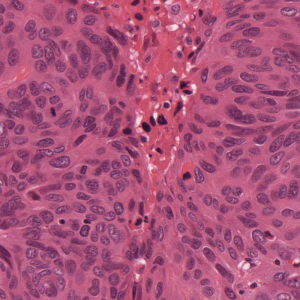

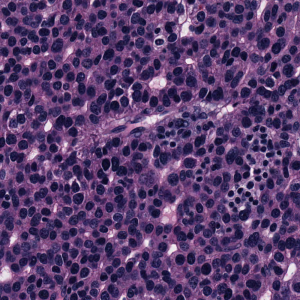

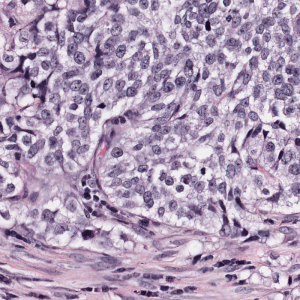

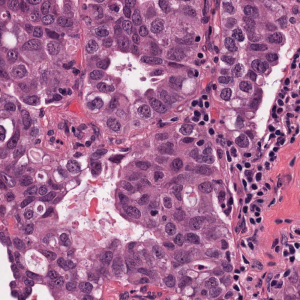

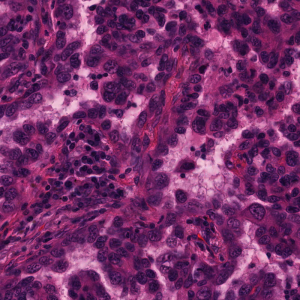

Black background training set tissue images:


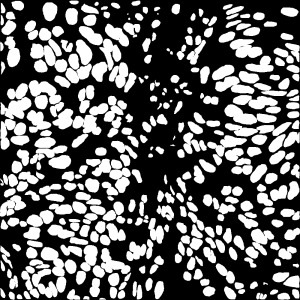

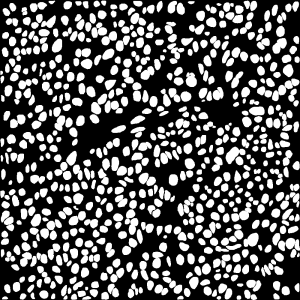

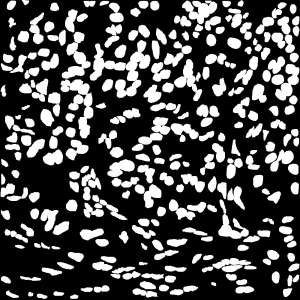

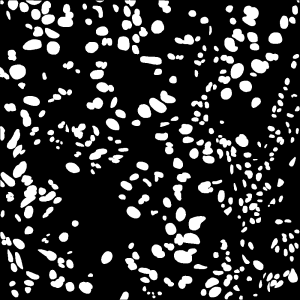

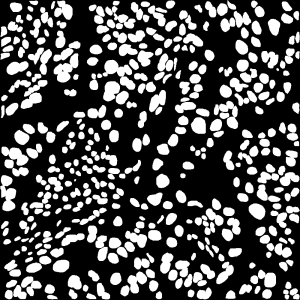

random color training set tissue images:


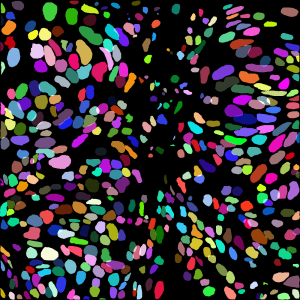

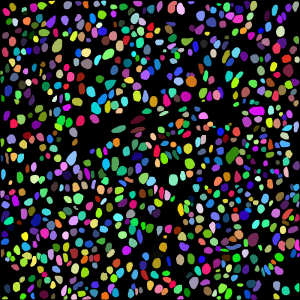

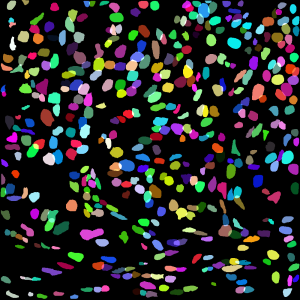

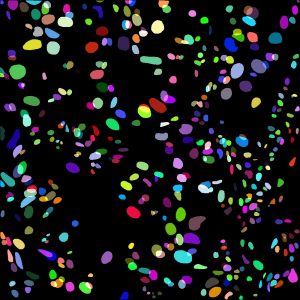

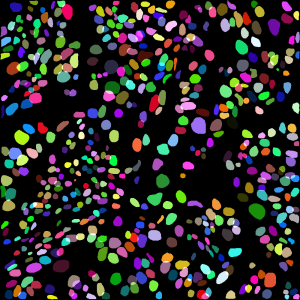

In [ ]:
#@title Question 1 Training set Tissue images, Binary mask images , Random color images
print('Training set Tissue Images:')
t1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-18-5592-01Z-00-DX1.png')
t1= scale(t1,30)
t2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-21-5784-01Z-00-DX1.png')
t2= scale(t2,30)
t3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-21-5786-01Z-00-DX1.png')
t3= scale(t3,30)
t4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-38-6178-01Z-00-DX1.png')
t4= scale(t4,30)
t5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/TCGA-49-4488-01Z-00-DX1.png')
t5= scale(t5,30)

cv2_imshow(t1)
cv2_imshow(t2)
cv2_imshow(t3)
cv2_imshow(t4)
cv2_imshow(t5)

print('Black background training set tissue images:')
b1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/TCGA-18-5592-01Z-00-DX1.png')
b1= scale(b1,30)
b2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/TCGA-21-5784-01Z-00-DX1.png')
b2= scale(b2,30)
b3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/TCGA-21-5786-01Z-00-DX1.png')
b3= scale(b3,30)
b4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/TCGA-38-6178-01Z-00-DX1.png')
b4= scale(b4,30)
b5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/TCGA-49-4488-01Z-00-DX1.png')
b5= scale(b5,30)
cv2_imshow(b1)
cv2_imshow(b2)
cv2_imshow(b3)
cv2_imshow(b4)
cv2_imshow(b5)

print('random color training set tissue images:')
c1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-18-5592-01Z-00-DX1.png')
c1= scale(c1,30)
c2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-21-5784-01Z-00-DX1.png')
c2= scale(c2,30)
c3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-21-5786-01Z-00-DX1.png')
c3= scale(c3,30)
c4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-38-6178-01Z-00-DX1.png')
c4= scale(c4,30)
c5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/TCGA-49-4488-01Z-00-DX1.png')
c5= scale(c5,30)
cv2_imshow(c1)
cv2_imshow(c2)
cv2_imshow(c3)
cv2_imshow(c4)
cv2_imshow(c5)

cv2.waitKey(0)
cv2.destroyAllWindows()



Test set Tissue Images:


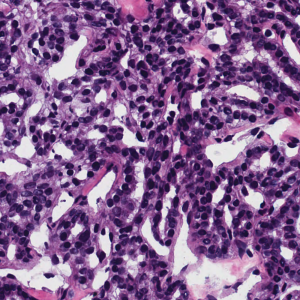

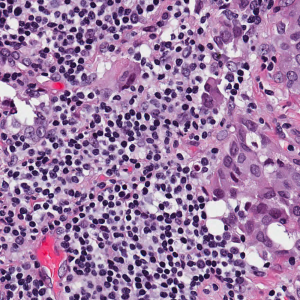

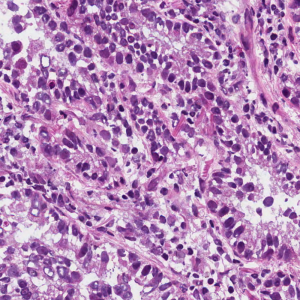

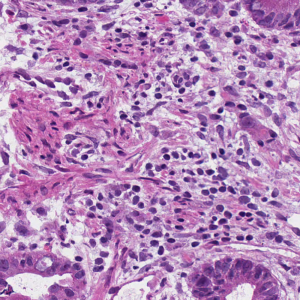

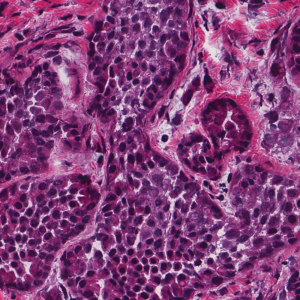

Black background Test set tissue images:


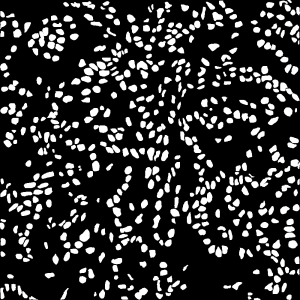

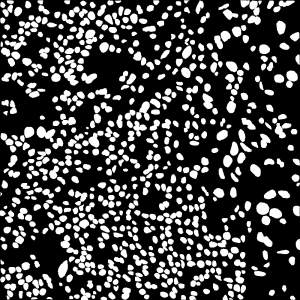

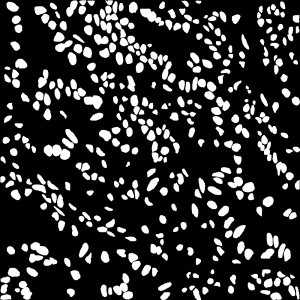

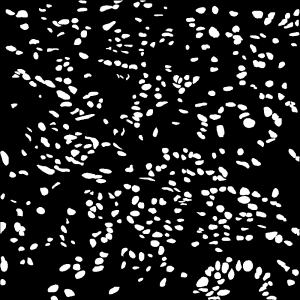

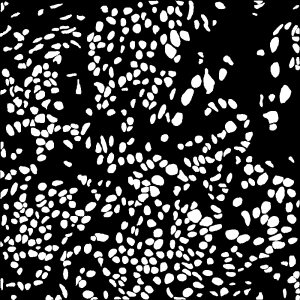

random color Test set tissue images:


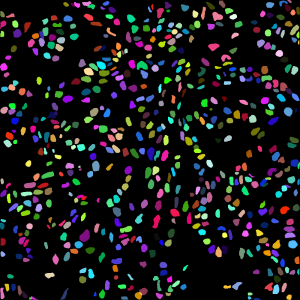

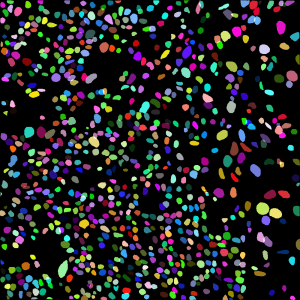

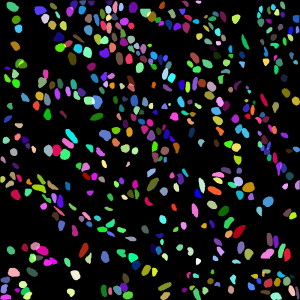

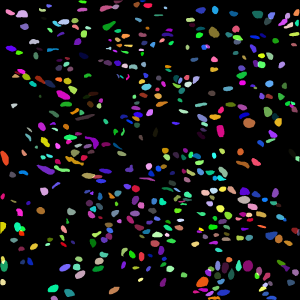

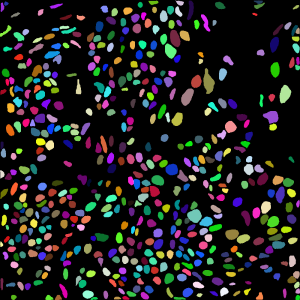

In [ ]:
#@title Question 1 Test set Tissue images, Binary mask images , Random color images
print('Test set Tissue Images:')
t1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-2Z-A9J9-01A-01-TS1.png')
t1= scale(t1,30)
t2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-44-2665-01B-06-BS6.png')
t2= scale(t2,30)
t3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-69-7764-01A-01-TS1.png')
t3= scale(t3,30)
t4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-A6-6782-01A-01-BS1.png')
t4= scale(t4,30)
t5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-AC-A2FO-01A-01-TS1.png')
t5= scale(t5,30)

cv2_imshow(t1)
cv2_imshow(t2)
cv2_imshow(t3)
cv2_imshow(t4)
cv2_imshow(t5)

print('Black background Test set tissue images:')
b1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-2Z-A9J9-01A-01-TS1.png')
b1= scale(b1,30)
b2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-44-2665-01B-06-BS6.png')
b2= scale(b2,30)
b3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-69-7764-01A-01-TS1.png')
b3= scale(b3,30)
b4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-A6-6782-01A-01-BS1.png')
b4= scale(b4,30)
b5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-AC-A2FO-01A-01-TS1.png')
b5= scale(b5,30)
cv2_imshow(b1)
cv2_imshow(b2)
cv2_imshow(b3)
cv2_imshow(b4)
cv2_imshow(b5)

print('random color Test set tissue images:')
c1= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-2Z-A9J9-01A-01-TS1.png')
c1= scale(c1,30)
c2= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-44-2665-01B-06-BS6.png')
c2= scale(c2,30)
c3= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-69-7764-01A-01-TS1.png')
c3= scale(c3,30)
c4= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-A6-6782-01A-01-BS1.png')
c4= scale(c4,30)
c5= cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/TCGA-AC-A2FO-01A-01-TS1.png')
c5= scale(c5,30)
cv2_imshow(c1)
cv2_imshow(c2)
cv2_imshow(c3)
cv2_imshow(c4)
cv2_imshow(c5)

cv2.waitKey(0)
cv2.destroyAllWindows()

42912.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


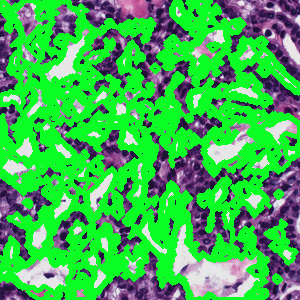

-1

In [ ]:
#@title Question 4 watershed algorithm implementation
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
# Load in image, convert to gray scale, and Otsu's threshold
gray = cv2.cvtColor(t1, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(t1, [c], -1, (36,255,12), 4)

print(total_area)
cv2_imshow(t1)
cv2.waitKey()

https://pynative.com/python-count-number-of-files-in-a-directory/#:~:text=Getting%20a%20count%20of%20files,of%20files%20of%20a%20directory.

https://realpython.com/python-append/#:~:text=Python%20provides%20a%20method%20called,Learning%20how%20to%20use%20.

https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

https://stackoverflow.com/questions/57813137/how-to-use-watershed-segmentation-in-opencv-python

https://www.youtube.com/watch?v=M3EZS__Z_XE